In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
df = pd.read_csv("Data/AAPL.csv")

In [3]:
df.index

RangeIndex(start=0, stop=1006, step=1)

In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1001,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800
1002,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896324,93121200
1003,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869423,146266000
1004,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290054,144114400
1005,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.810936,100805600


In [5]:
df_1=df.reset_index()['Close']

In [6]:
df_1.head()

0    26.337500
1    25.677500
2    25.174999
3    24.112499
4    24.240000
Name: Close, dtype: float64

In [7]:
df_1.shape

(1006,)

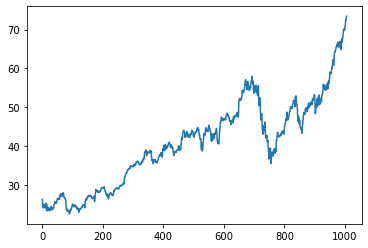

In [8]:
#temp viz
import matplotlib.pyplot as plt
plt.plot(df_1)

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
arr = np.array(df_1).reshape(-1,1)

In [11]:
df_1 = scaler.fit_transform(arr)

In [12]:
df_1.shape

(1006, 1)

In [13]:
#train test split
training_size = int(len(df_1)*0.70)
test_size = len(df_1) - training_size
train_data,test_data = df_1[0:training_size,:],df_1[training_size:len(df_1),:1]

In [14]:
training_size,test_size

(704, 302)

In [15]:
len(train_data),len(test_data)

(704, 302)

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(603, 100)
(603,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
print(X_train.shape), print(y_train.shape)

(603, 100, 1)
(603,)


(None, None)

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=1,batch_size=64,verbose=1)

10/10 [==============================] - 6s 207ms/step - loss: 0.0363 - val_loss: 0.0227


In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 0s 20ms/step


In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
math.sqrt(mean_squared_error(y_train,train_predict))

38.05262971928568

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

47.55336269563866

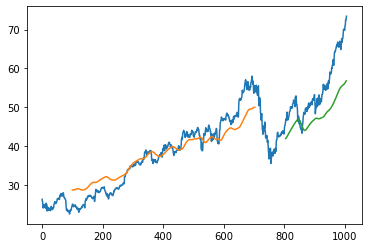

In [28]:
### temp Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
x_input = df_1[len(df_1)-100:].reshape(1,-1)

In [30]:
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)

In [32]:
temp_input=temp_input[0].tolist()

In [33]:
temp_input

[0.5442428335251157,
 0.5417343008816189,
 0.5834932187662019,
 0.5528995377106969,
 0.5479317814814693,
 0.5713442774924642,
 0.5902809070224806,
 0.59033006597657,
 0.6015444617597376,
 0.6006591502750951,
 0.5523584890083582,
 0.5712951185383746,
 0.5598347778810826,
 0.5665732321314332,
 0.5836899296343985,
 0.582361962407435,
 0.5674093846619861,
 0.5845753161708793,
 0.6046923610137522,
 0.6045939680537347,
 0.6090699095865515,
 0.6215139546885033,
 0.6554030869121303,
 0.6529437882745612,
 0.6315970941129039,
 0.637253450958577,
 0.6411883437890551,
 0.6513698761734732,
 0.6424672271137675,
 0.6265801038777485,
 0.6314495421987967,
 0.6263341590036238,
 0.6428114898960713,
 0.6372042920044876,
 0.631941431947046,
 0.6572721778932709,
 0.6603216841872683,
 0.6326300325634917,
 0.6417786264973218,
 0.6722246805868812,
 0.672470625461006,
 0.6593871386966978,
 0.672323073546899,
 0.687373969200527,
 0.7174758355596211,
 0.7158034554466772,
 0.7130982869868219,
 0.7084255595339704,


In [34]:
# demonstrate prediction for next 30 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.6793838]
101
1 day input [0.5417343  0.58349322 0.55289954 0.54793178 0.57134428 0.59028091
 0.59033007 0.60154446 0.60065915 0.55235849 0.57129512 0.55983478
 0.56657323 0.58368993 0.58236196 0.56740938 0.58457532 0.60469236
 0.60459397 0.60906991 0.62151395 0.65540309 0.65294379 0.63159709
 0.63725345 0.64118834 0.65136988 0.64246723 0.6265801  0.63144954
 0.62633416 0.64281149 0.63720429 0.63194143 0.65727218 0.66032168
 0.63263003 0.64177863 0.67222468 0.67247063 0.65938714 0.67232307
 0.68737397 0.71747584 0.71580346 0.71309829 0.70842556 0.7129015
 0.71845954 0.73862574 0.73592058 0.75175839 0.75372587 0.76848167
 0.78063061 0.75229944 0.75215189 0.77920417 0.81392953 0.82219274
 0.82037288 0.82091386 0.8316856  0.83517791 0.84531021 0.84412964
 0.85647537 0.8474744  0.8628204  0.8694113  0.86542725 0.85017957
 0.84437566 0.84324433 0.86582067 0.85559006 0.87305102 0.87014906
 0.85495061 0.83178406 0.84304754 0.86193494 0.88716737 0.86852599
 0.87619899 0.88746247 0.89085631 0

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [36]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

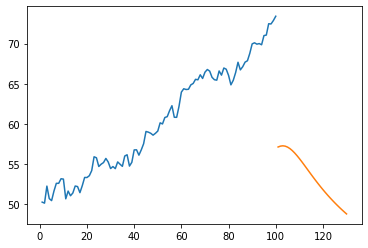

In [37]:
plt.plot(day_new,scaler.inverse_transform(df_1[len(df_1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [38]:
# df3=df_1.tolist()
# df3.extend(lst_output)
# plt.plot(df3[500:])